In [71]:
%run function_dbs.py
%run MLRegression_dbs.py
%matplotlib inline

fs, color = 10, 'k'
today = ''.join(str(datetime.today()).split(' ')[0].split('-'))

## load spectral data and calibration information

In [11]:
# define path to where to find the absolute fluorescence intensity
ddata = pd.read_csv('460nm/20220831_trainingData_absoluteIntensity.csv', index_col=0).astype(float)
ddata.columns = [float(i) for i in ddata.columns[:-2]] + ['pH', 'O2 (%O2)']

# fluorescence spectra as features
df_features_ = ddata.loc[:, 470:900]

# adjust the precision: pH 1xdecimal, O2 1xdecimal
target_pH, target_O2 = [round(p,1) for p in ddata['pH']], [round(p,0) for p in ddata['O2 (%O2)']]

# --------------------------------
ddata.head(5)

,470.0,472.8859,475.7718,478.6577,481.5436,484.4295,487.3154,490.2013,493.0872,495.9732,...,879.7987,882.6846,885.5705,888.4564,891.3423,894.2282,897.1141,900.0,pH,O2 (%O2)
0,0.627993,0.786419,0.857007,1.009259,1.208525,1.668691,1.633192,1.607212,1.570307,1.635793,...,0.035707,0.034556,0.033926,0.033197,0.029638,0.026824,0.024484,0.022881,7.0,6.01
1,0.694880,0.943585,1.030970,1.118346,1.360172,1.732881,1.903371,1.945338,1.857719,1.744565,...,0.039210,0.039139,0.035852,0.034511,0.032512,0.029335,0.026468,0.025315,7.0,6.01
2,0.427785,0.518845,0.846070,0.912887,1.217220,1.579858,1.616807,1.691709,1.653757,1.591611,...,0.032027,0.032745,0.032808,0.030662,0.026061,0.023218,0.021797,0.021212,7.0,6.01
3,0.676768,0.894154,1.109482,1.324799,1.515610,1.622339,1.627091,1.709985,1.769908,1.692980,...,0.036324,0.036585,0.035338,0.031950,0.027525,0.024393,0.021351,0.019873,7.0,6.01
4,0.826063,0.940941,0.918367,0.932857,1.273592,1.556148,1.644203,1.688227,1.474947,1.443371,...,0.033894,0.033062,0.032154,0.029812,0.028457,0.027119,0.024030,0.021251,7.0,6.01


Check the inbalance of the data set 

- O2 is highly imbalanced in particular for 0% and 20%
- Quick note on how to deal with an imbalanced dataset: https://towardsdatascience.com/how-to-balance-a-dataset-in-python-36dff9d12704

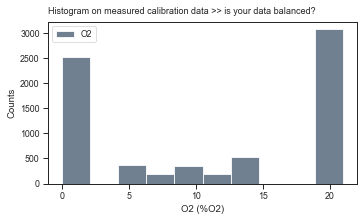

In [25]:
fig, ax = plt.subplots(figsize=(5,3))
fig.suptitle('Histogram on measured calibration data >> is your data balanced?', fontsize=9)

ax.hist(target_O2, color='slategrey', label='O2')
ax.legend(loc=2)
ax.set_ylabel('Counts'), ax.set_xlabel('O2 (%O2)')
plt.tight_layout(pad=0.5)

# Prepare data set for O2

##### balance data set

In [16]:
df_features = pd.concat([df_features_, pd.DataFrame(target_pH, columns=['pH'])], axis=1)
df_features.index = pd.DataFrame(target_O2)[0].to_numpy()
print('raw data available: ', df_features.shape[0])

n_count_median = int(pd.DataFrame(target_O2).value_counts().median())
print('average sample size for each calibration point: ', n_count_median)

raw data available:  7196
average sample size for each calibration point:  447


In [35]:
### data adjustment

# get the O2 points that are above the median
df_2smooth = pd.DataFrame(target_O2).value_counts()[pd.DataFrame(target_O2).value_counts() > n_count_median]
ls_smooth_O2 = [x[0] for x in pd.DataFrame(df_2smooth).index]

# group prevailing data to larger chunks and smooth spectral information
df_ox_sm = data_smoothing(n_count_median=n_count_median, df_features=df_features, ls_smooth=ls_smooth_O2, analyte='O2')  

# --------------------------------------------------------------------
# re-combine reduced data set to the one that did not get smoothed -> balanced data set
ls_O2_remain = list(dict.fromkeys(target_O2)).copy()
[ls_O2_remain.remove(o) for o in ls_smooth_O2]

df_features.loc[:, 'O2 (%O2)'] = df_features.index
df_features_balanced = pd.concat([df_ox_sm, df_features.loc[ls_O2_remain]], axis=0)
df_features_balanced = df_features_balanced.sort_index()
df_features_ml = df_features_balanced.loc[:, 470:'pH']

# --------------------------------------------------------------------
# replace NaN values in dataFrame
df_features_ml = _replace_nan(df_features_ml, analyte='O2 (%O2)')

print('>> amount of NaNs in data set:', df_features_ml.isnull().sum().sum())
print('>> data points available upon balancing:', df_features_ml.shape[0])

/Applications/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Applications/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Applications/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


>> amount of NaNs in data set: 0
>> data points available upon balancing: 2506


the data set is still bit unbalanced, but already much better than before


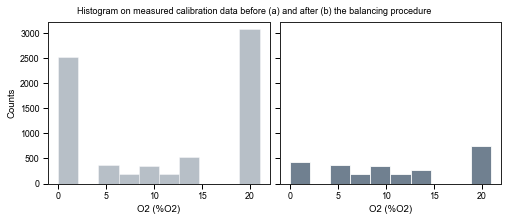

In [73]:
print('the data set is still bit unbalanced, but already much better than before')

# ---------------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7,3), ncols=2, sharex=True, sharey=True)
fig.suptitle('Histogram on measured calibration data before (a) and after (b) the balancing procedure', fontsize=9, color=color)

ax[0].hist(target_O2, color='slategrey', label='O2', alpha=0.5)
ax[1].hist(df_features_ml.index, color='slategrey')
ax[0].set_ylabel('Counts', color=color), ax[0].set_xlabel('O2 (%O2)', color=color), ax[1].set_xlabel('O2 (%O2)', color=color)
ax[0].tick_params(axis='both', colors=color), ax[1].tick_params(axis='both', colors=color)

plt.tight_layout(pad=0.5)

# ---------------------------------------------------------------------------------------
# save plot
# fig.savefig('BalancedData_O2.svg', transparent=True, dpi=300)

## Save balanced data set

In [74]:
df_features_ml.to_csv(today + '_TrainingData-O2_balanced_absoluteInt.csv', sep='\t', decimal='.')

## Training data set inspection

In [88]:
# split the data into training and validation data
y_truth = df_features_ml.index              # n_samples (2506,) chosen analyte
X = df_features_ml                          # shape (n_features, n_samples) with (2506, 151)

X_train, X_valid, truth_train, truth_valid = train_test_split(X, y_truth, test_size=0.1, random_state=42)
X_train, X_valid = X_train.T, X_valid.T

print('in ML a rule of thumbs says that a suitable size for a data set is >1,000 samples')
print('size of data sets:')
print('> training data  ', X_train.shape, '\n> validation data', X_valid.shape)

in ML a rule of thumbs says that a suitable size for a data set is >1,000 samples
size of data sets:
> training data   (151, 2255) 
> validation data (151, 251)


In [77]:
# PCA as initial check whether a pattern is visible

# unsupervised dimension reduction for array-like data sets of shape (n_samples, n_features)
pca = PCA(n_components=min(X_train.shape), random_state=42)  
pca.fit(np.array(X_train).T)                                

# apply transform to dataset
X_train_dim_ = pca.transform(np.array(X_train).T)
X_valid_dim_ = pca.transform(np.array(X_valid).T)

print('[RESULTS]\n   ', pca)

[RESULTS]
    PCA(n_components=151, random_state=42)


The covariance shows which parameters are more important for separation (the brighter the more important). As it can be seen from the plot the wavelengths between 470-500nm (parameters 0-10) and 730-830 (parameters 91-126) are more important.

>> explained variance with PC1-22: 99.951%


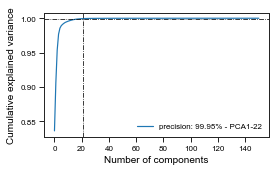

In [78]:
# which precision is sufficient?
precision = .9995

# find the PCAs that are needed to match the precision
cut = [k+1 for k, c in enumerate(np.cumsum(pca.explained_variance_ratio_)) if c < precision]

if len(cut) > 1:
    print('>> explained variance with PC1-{}: {:.3f}%'.format(cut[-1]+1, np.cumsum(pca.explained_variance_ratio_)[cut[-1]]*100))
    X_train_dim, X_valid_dim = X_train_dim_[:, :cut[-1]+1], X_valid_dim_[:, :cut[-1]+1]
else:
    X_train_dim, X_valid_dim = X_train_dim_, X_valid_dim_
    
# ------------------------------------------------------------------------------------------
# plot results
fig, ax = plt.subplots(figsize=(4,2.4))

ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.axhline(precision, lw=0.75, color=color, ls='-.')
if len(cut) > 1: 
    ax.axvline(cut[-1], color=color, lw=0.75, ls='-.')
else:
    cut = ['']
ax.legend(['precision: ' + str(precision*100) + '% - PCA1-{}'.format(cut[-1]+1) ], fontsize=8, frameon=False, labelcolor=color)

ax.set_xlabel('Number of components', fontsize=fs, color=color)
ax.set_ylabel('Cumulative explained variance', fontsize=fs, color=color)
ax.tick_params(labelsize=fs*0.8, labelcolor=color),
plt.tight_layout()
 
# ------------------------------------------------------------------------------------------
# save plot
# fig.savefig('CumVariance-O2_absoluteInt_{}.svg'.format(color), transparent=True, dpi=300)

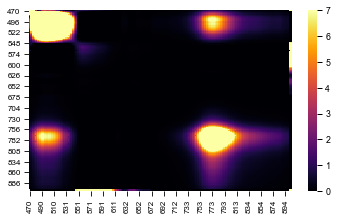

In [13]:
fig, ax = plt.subplots(figsize=(5,3))

sns.heatmap(pca.get_covariance() / np.nanmean(pca.get_covariance()), ax=ax, vmin=0, vmax=7, cmap='inferno')
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(colors=color)

ax.set_xticklabels([int(round(df_features_ml.columns[n*7],0)) for n in np.arange(22)])
ax.set_yticklabels([int(round(df_features_ml.columns[n*9],0)) for n in np.arange(17)])

ax.tick_params(labelsize=fs*0.8, labelcolor=color)
plt.tight_layout(pad=0.5)

# ------------------------------------------------------------------------------------------
# save plot
# fig.savefig('RelativeCovariance-O2_absoutInt_{}.svg'.format(color), transparent=True, dpi=300)

## Screening of different ML regression algorithms

the performance of the models is compared based on the mean absolute error (MAE) and the root-mean-square deviation/error (RMSE)

In [86]:
# 1) linear Regression 
reg_lin = make_pipeline(preprocessing.StandardScaler(), LinearRegression())

# 2) lasso Regression
reg_lasso = make_pipeline(preprocessing.StandardScaler(), Lasso())

# 3) rigide Regression
reg_rig = make_pipeline(preprocessing.StandardScaler(), Ridge())

# 4) logistic Regression
reg_log = make_pipeline(preprocessing.StandardScaler(), LogisticRegression())

# -------------------------------------------------------------
# 5) RandomForest Regression
reg_randF = make_pipeline(preprocessing.StandardScaler(), RandomForestRegressor())

# 6) SVM model
reg_SVR = make_pipeline( preprocessing.StandardScaler(), SVR())

# 7) K Nearest Neighbours
reg_kNN = make_pipeline(preprocessing.StandardScaler(), KNeighborsRegressor(n_neighbors=3))

# 8) Decision Tree
reg_DT = make_pipeline(preprocessing.StandardScaler(), DecisionTreeRegressor())

# 9) Xgboost
reg_XGB = make_pipeline(preprocessing.StandardScaler(), XGBRegressor())


# -------------------------------------------------------------
# combine all models
models_all = [reg_lin, reg_lasso, reg_rig, reg_log, reg_randF, reg_SVR, reg_kNN, reg_DT, reg_XGB]
methods = ['LIN', 'LAS', 'RIG', 'LOG', 'RF', 'SVR', 'kNN', 'DT', 'XGB']

In [87]:
# predict model performance for traning and validation data
derror = _perdict_model_performance(X_train=X_train_dim, X_valid=X_valid_dim, truth_train=truth_train, truth_valid=truth_valid, 
                                    methods=methods, models_all=models_all)
df_error = pd.concat(derror)

# -------------------------------------------------------------
print('Model performance without hyperparameter optimization\n')
pd.concat(derror)

/Users/au652733/Python/Project_pH+O2/MLRegression_dbs.py:254: RuntimeWarning: invalid value encountered in true_divide
  z = (y_pred - y_true) / y_true


Model performance without hyperparameter optimization



mae        rmse       sdz
LinearRegression      training   2.504445    2.889028       inf
                      test       2.477195    2.925690       inf
Lasso                 training   2.807404    3.302090       inf
                      test       2.788077    3.265688       inf
Ridge                 training   2.504918    2.889029       inf
                      test       2.477422    2.925454       inf
LogisticRegression    training  39.423503  119.552009  0.089272
                      test      43.426295  133.150605  0.098913
RandomForestRegressor training   0.083419    0.259377       inf
                      test       0.282191    0.828022       inf
SVR                   training   1.794522    2.583288       inf
                      test       2.110134    2.844955       inf
KNeighborsRegressor   training   2.011973    3.037541       inf
                      test       2.933599    4.151460       inf
DecisionTreeRegressor training   0.000000    0.000000  0.000000
                      test       0.219124    1.039077  0.135670
XGBRegressor          training   0.019457    0.029454       inf
                      test       0.346106    0.917334       inf

In [117]:
print('Best performing ML algorithm(s)')

dT1 = pd.concat(derror).T.filter(like='training').T.sort_values('mae')['mae'][:3].index
dT2 = pd.concat(derror).T.filter(like='training').T.sort_values('rmse')['rmse'][:3].index
dv1 = pd.concat(derror).T.filter(like='test').T.sort_values('mae')['mae'][:3].index
dv2 = pd.concat(derror).T.filter(like='test').T.sort_values('rmse')['rmse'][:3].index

print('>> for training data: \t', sorted(list(dict.fromkeys([v[0] for v in dT1] + [v[0] for v in dT2]))))
print('>> for test data: \t', sorted(list(dict.fromkeys([v[0] for v in dv1] + [v[0] for v in dv2]))))

Best performing ML algorithm(s)
>> for training data: 	 ['DecisionTreeRegressor', 'RandomForestRegressor', 'XGBRegressor']
>> for test data: 	 ['DecisionTreeRegressor', 'RandomForestRegressor', 'XGBRegressor']
